In [1]:
# Create spark session
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import os
os.environ['HADOOP_HOME'] = "C:\spark\spark-3.2.0-bin-hadoop2.7"
os.environ['SPARK_HOME'] = "C:\spark\spark-3.2.0-bin-hadoop2.7"

spark = SparkSession.builder.appName('CSCI316-groupAss2')\
.config('spark-master', 'local')\
.getOrCreate()

# output the object (spark) information
spark

In [2]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import isnan, when, count, col
import pandas as pd

In [3]:
##dun want to see too many warning 
import warnings

warnings.filterwarnings('ignore')

In [4]:
# Read a covtype file from local disk
path ='C:/Users/Morgan/Documents/316/A2 GRP/covtype.data'
df = spark.read.format('csv')\
.option('header', 'false')\
.option('inferSchema', 'true')\
.load(path)\
.toDF("Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
                "Horizontal_Distance_To_Fire_Points", "Wilderness_Area1", "Wilderness_Area2",
                "Wilderness_Area3", "Wilderness_Area4", "Soil_Type1", 
                "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", 
                "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10", 
                "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15", 
                "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", 
                "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25", 
                "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30", 
                "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", 
                "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", 
                "Soil_Type40", "Cover_Type") # changing the header

#Display total row
print("Total row:",df.count())

#Display schema
df.printSchema()

Total row: 581012
root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- S

# DATA CHECKING

In [5]:
#Checking if all the column contain NAN
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

#Checking 0 in cover_type as it can only have 1-7
frame = df.where(df.Cover_Type==0).count()
print("Number of 0 in Cover_Type:",frame)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

In [6]:
#to check if Cover Type have 0 
df.select("Cover_Type").where(df.Cover_Type==0).count()


0

In [7]:
# to check if have column is null 
count_null= df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns])
for i in range((len(df.columns)//4)+1):
    count_null.select(df.columns[i*4:i*4+4]).show()

+---------+------+-----+--------------------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|
+---------+------+-----+--------------------------------+
|        0|     0|    0|                               0|
+---------+------+-----+--------------------------------+

+------------------------------+-------------------------------+-------------+--------------+
|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|
+------------------------------+-------------------------------+-------------+--------------+
|                             0|                              0|            0|             0|
+------------------------------+-------------------------------+-------------+--------------+

+-------------+----------------------------------+----------------+----------------+
|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|
+-------------+----------------------------------+----------------+-

# CORRELATION COEFFICIENT

In [8]:
#improrting pandas for visualization
import pandas as pd

#Setting max row to None to show all rows when displaying a pandas object
pd.set_option("display.max_rows", None)

#Convert to pandas
df_pandas = df.toPandas()
print(df_pandas[:3])

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   
2                                6121

get correl of selected attribute to all attribute using corr()

In [9]:
#df_pandas["Cover_Type"] = pd.factorize(df_pandas["Cover_Type"])[0].astype(np.uint16)
corr_matrix=df_pandas.corr()
#corr_matrix
corr_matrix["Cover_Type"].sort_values(ascending=False)



Cover_Type                            1.000000
Wilderness_Area4                      0.323200
Soil_Type10                           0.243876
Soil_Type38                           0.160170
Soil_Type39                           0.155668
Slope                                 0.148285
Soil_Type40                           0.128351
Soil_Type2                            0.118135
Soil_Type6                            0.112958
Soil_Type4                            0.099672
Soil_Type1                            0.090828
Soil_Type17                           0.090582
Vertical_Distance_To_Hydrology        0.081664
Soil_Type35                           0.080315
Soil_Type37                           0.080271
Soil_Type5                            0.077890
Soil_Type3                            0.068064
Wilderness_Area3                      0.066846
Soil_Type14                           0.065562
Soil_Type11                           0.035379
Soil_Type36                           0.025397
Soil_Type13  

The result display the strongest and weakest relationship with the selected attribute

# VISUALIZATION

array([[<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Aspect'}>,
        <AxesSubplot:title={'center':'Slope'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Roadways'}>,
        <AxesSubplot:title={'center':'Hillshade_9am'}>],
       [<AxesSubplot:title={'center':'Hillshade_Noon'}>,
        <AxesSubplot:title={'center':'Hillshade_3pm'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Fire_Points'}>,
        <AxesSubplot:title={'center':'Wilderness_Area1'}>,
        <AxesSubplot:title={'center':'Wilderness_Area2'}>,
        <AxesSubplot:title={'center':'Wilderness_Area3'}>,
        <AxesSubplot:title={'center':'Wilderness_Area4'}>],
       [<AxesSubplot:title={'center':'Soil_Type1'}>,
        <AxesSubplot:title={'center':'Soil_Type2'}>,
        <AxesSubplot:title={'center':'S

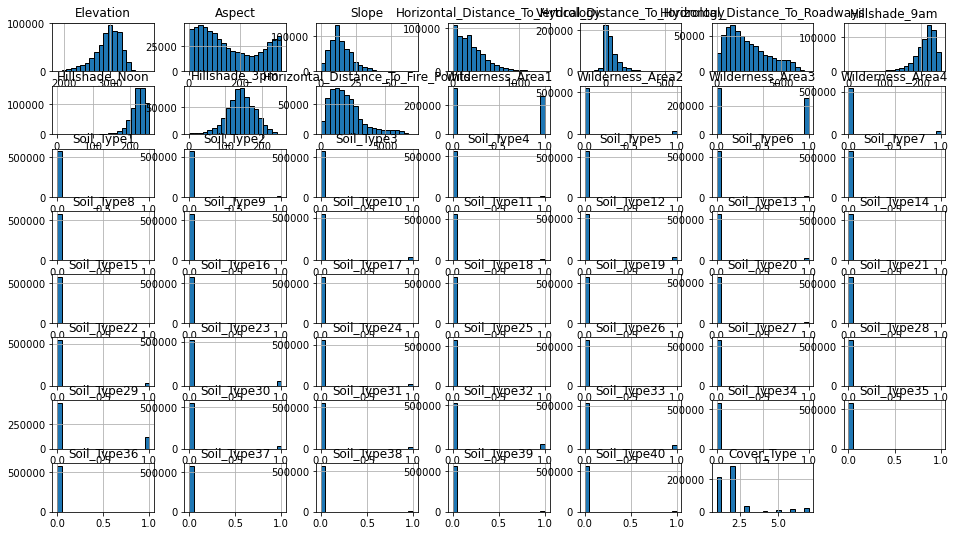

In [10]:
df_pandas.hist(figsize=(16,9), edgecolor="black", bins=20)


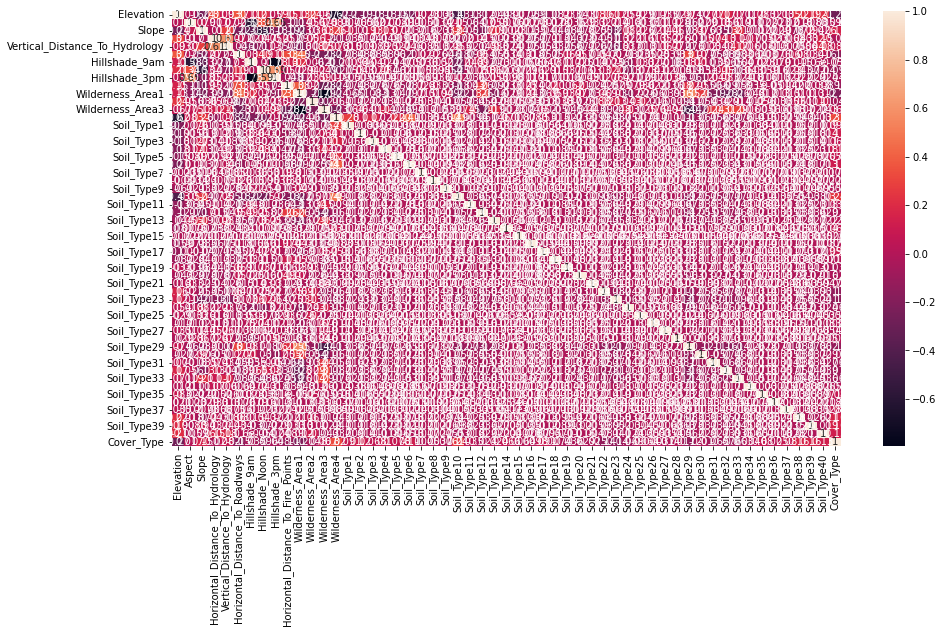

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

# visualize the correlation of all columns in this dataframe
plt.figure(figsize=(15,8))

# using heapmap to plot
sns.heatmap(df_pandas.corr(), annot=True)

# show the plot
plt.show()

The plot looks abit bad for a correlation chart.We will reduce the number of attributes to just soil_types against the cover_type

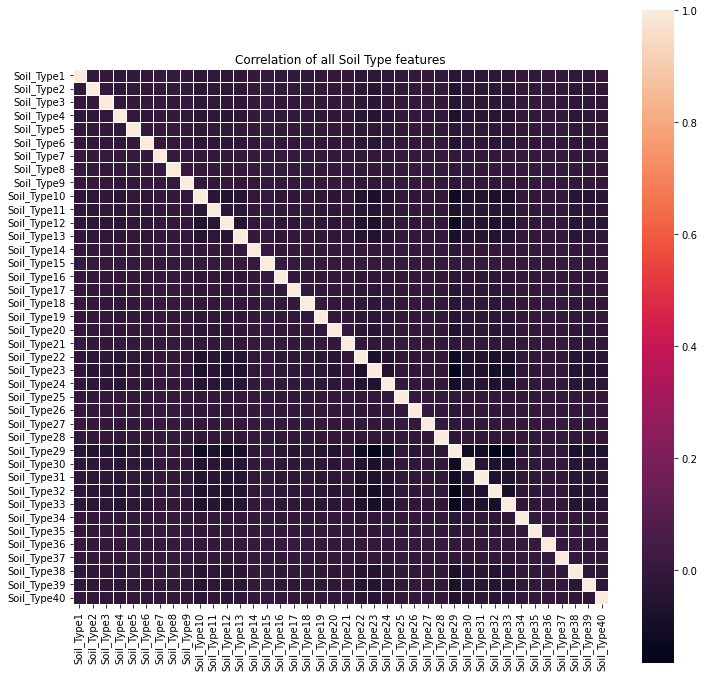

In [12]:
# get and store all the Soil Type features
columns = [cols for cols in df_pandas.columns if str(cols).startswith('Soil')]

# set the figure size
plt.figure(figsize=(12, 12))

# using heapmap to plot
sns.heatmap(df_pandas[columns].corr(), square=True, linewidths=1)

# set the title of the plot
plt.title('Correlation of all Soil Type features')

# show the plot
plt.show()

There is not any correlation between the soil_types. Hence, we try the remaining columns to see their correlations.

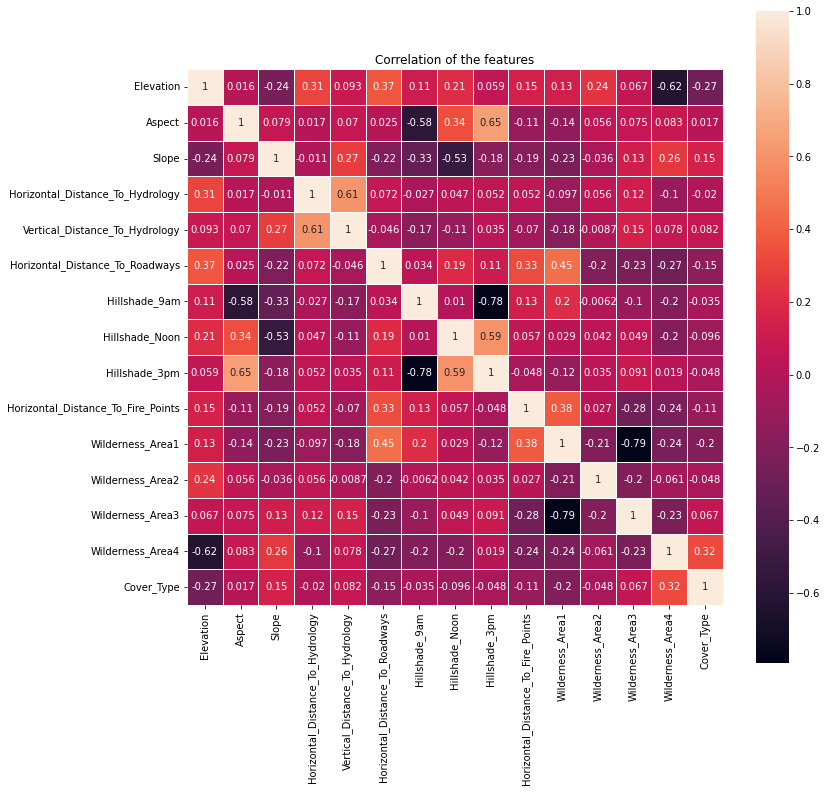

In [13]:
# get and store all the not Soil Type features
columns = [cols for cols in df_pandas.columns if not str(cols).startswith('Soil')]

# set the figure size
plt.figure(figsize=(12, 12))

# using heapmap to plot
sns.heatmap(df_pandas[columns].corr(), square=True, linewidths=1, annot = True)

# set the title of the plot
plt.title('Correlation of the features')

# show the plot
plt.show()

From the plot we can see that:

(1) We can get good info for Cover_Type for Wilderness_Area_4 (0.32) as is has strong positive correlation.

(2) Slope is the second highest with 0.15

(3) The weakest relationship is elevation which means we the possibility is very low for us to get good info from it

# Data Preparation

In [14]:
#Creating pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

#Drop cover_type to create "features" dataset
features = df.drop("Cover_Type")

#Declare "assembler" to assemble all attribute column to "features" column
assembler = VectorAssembler(inputCols = features.columns, outputCol="features")

#Declare "scaler" to scale "features" and make "features_scaled"
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

#Making the pipeline
pipeline = Pipeline().setStages([assembler,scaler])

#fit and transform dataset into pipeline
assembled_df = pipeline.fit(df).transform(df)

#extract "features_scaled" and "cover_type" from dataset and rename "features_scaled" into "features"
assembled_df = assembled_df.select("features_scaled","Cover_Type").withColumnRenamed("features_scaled","features")

Splitting dataset

the Data of split to test and train are not stratify samplinf 

In [15]:
seed=assembled_df.select("Cover_Type").count()
seed

581012

In [16]:
# use cover_type as fraction to make stratify sampling lit2/3 means take 2/3 
fractions = assembled_df.select("Cover_Type").distinct().withColumn("fraction", lit(2/3)).rdd.collectAsMap()
print(fractions)  

{1: 0.6666666666666666, 6: 0.6666666666666666, 3: 0.6666666666666666, 5: 0.6666666666666666, 4: 0.6666666666666666, 7: 0.6666666666666666, 2: 0.6666666666666666}


In [17]:
# stratify sampling to split out the training set 
train_df = assembled_df.stat.sampleBy("Cover_Type", fractions, seed)
train_df.groupby("Cover_Type").count().show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         1|140991|
|         6| 11638|
|         3| 23857|
|         5|  6260|
|         4|  1843|
|         7| 13647|
|         2|189421|
+----------+------+



In [18]:
# we already take out the trainset so we use subtract we can get the test-trian 
test_df = assembled_df.subtract(train_df)
test_df.groupby("Cover_Type").count().show()

+----------+-----+
|Cover_Type|count|
+----------+-----+
|         1|70849|
|         6| 5729|
|         3|11897|
|         5| 3233|
|         4|  904|
|         7| 6863|
|         2|93880|
+----------+-----+



# Training model

Decision Tree

In [19]:
#Build decision tree classifier  model
dt= DecisionTreeClassifier(featuresCol="features",labelCol="Cover_Type")

#fit the model
fit_dt = dt.fit(train_df)

#get prediction
predict_dt = fit_dt.transform(test_df)
#get prediction for train 
predict_dt_tr=fit_dt.transform(train_df)

#display prediction
predict_dt.select("Cover_Type","prediction").show(5)

+----------+----------+
|Cover_Type|prediction|
+----------+----------+
|         2|       2.0|
|         2|       2.0|
|         1|       1.0|
|         5|       2.0|
|         4|       3.0|
+----------+----------+
only showing top 5 rows



Random Forest

In [20]:
#Build random forest classifier model
rf= RandomForestClassifier(featuresCol="features",labelCol="Cover_Type",numTrees=50)

#fit the model
fit_rf = rf.fit(train_df)

#get prediction
predict_rf = fit_rf.transform(test_df)
#get prediction for train 
predict_rf_tr=fit_rf.transform(train_df)

#display prediction
predict_rf.select("Cover_Type","prediction").show(5)

+----------+----------+
|Cover_Type|prediction|
+----------+----------+
|         2|       2.0|
|         2|       2.0|
|         1|       1.0|
|         5|       2.0|
|         4|       3.0|
+----------+----------+
only showing top 5 rows



Logistics Reggression

In [21]:
#Build logistics regression 
lin= LogisticRegression(featuresCol="features",labelCol="Cover_Type", maxIter=15)

#fit the model
fit_lin = lin.fit(train_df)

#get prediction
predict_lin = fit_lin.transform(test_df)
#get prediction for train 
predict_lin_tr=fit_lin.transform(train_df)

#display prediction
predict_lin.select("Cover_Type","prediction").show(5)

+----------+----------+
|Cover_Type|prediction|
+----------+----------+
|         2|       2.0|
|         2|       2.0|
|         1|       1.0|
|         5|       2.0|
|         4|       3.0|
+----------+----------+
only showing top 5 rows



# Evaluation before fine-tune

Accuracy 

In [22]:
dt_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName="accuracy")

accuracy = dt_evaluator.evaluate(predict_dt)
accuracy1 = dt_evaluator.evaluate(predict_rf)
accuracy2 = dt_evaluator.evaluate(predict_lin)
accuracy_tr = dt_evaluator.evaluate(predict_dt_tr)
accuracy1_tr = dt_evaluator.evaluate(predict_rf_tr)
accuracy2_tr = dt_evaluator.evaluate(predict_lin_tr)
print('Decision tree accuracy for test : ',accuracy)

print('Decision tree accuracy for train : ',accuracy_tr)

print('Random forest accuracy for test: ',accuracy1)
print('Random forest accuracy for train: ',accuracy1_tr)

print('logistic regression accuracy for test: ',accuracy2)
print('logistic regression accuracy for train: ',accuracy2_tr)



Decision tree accuracy for test :  0.6975563083447545
Decision tree accuracy for train :  0.6989374627570248
Random forest accuracy for test:  0.6686198960461328
Random forest accuracy for train:  0.6694397366744312
logistic regression accuracy for test:  0.7114323394791963
logistic regression accuracy for train:  0.7114407839920341


#### Findings:
    
(1) Based on the above result, we can see that for decision tree train test is 70.06% accuracy and the test set is 70.28% accuracy which means it only has 0.22% difference. Hence, overfitting does not occur

(2) Based on the above result, we can see that for random forest train test is 67.45% accuracy and the test set is 67.56% accuracy which means it only has 0.1% difference. Hence, overfitting does not occur

(3) Based on the above result, we can see that for logistic regression train test is 71.143% accuracy and the test set is 71.144% accuracy which means it only has 0.001% difference. Hence, overfitting does not occur

# FINE TUNING

Decision Tree

In [23]:
import numpy as np
# decision tree
decisiontree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Cover_Type')

#tuning paramters
param_grid = ParamGridBuilder()\
    .addGrid(decisiontree.maxDepth, [int(x) for x in np.linspace(start = 2, stop = 15, num = 3)]) \
    .addGrid(decisiontree.maxBins, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()


decisiontree_evaluator= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName="accuracy")

# applying 3 folds cross validation
cv_dt = CrossValidator(estimator=decisiontree, 
                               estimatorParamMaps=param_grid,
                               evaluator = decisiontree_evaluator,
                               numFolds=3
                              )
# Fitting and prediction


In [24]:
cvModel_dt = cv_dt.fit(train_df)
predictions_dt = cvModel_dt.transform(test_df)



In [25]:
predictions_dt_tr = cvModel_dt.transform(train_df)

In [26]:
# to get the best parameter 
bestModel = cvModel_dt.bestModel
print('maxBins - ', bestModel.getOrDefault('maxBins'))
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

maxBins -  15
maxDepth -  15


In [27]:
# to get the accuracy 
final_evaluator_ = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName="accuracy")
dt_hp = final_evaluator_.evaluate(predictions_dt)
dt_hp

0.8460655271391999

In [28]:
dt_hp_tr = final_evaluator_.evaluate(predictions_dt_tr)

Random Forest

In [29]:
# Random forest:
Randomforest = RandomForestClassifier(featuresCol = 'features', labelCol = 'Cover_Type')

# tuning paramteres:
param_grid = ParamGridBuilder() \
    .addGrid(Randomforest.maxDepth,[2,5,10]) \
    .addGrid(Randomforest.numTrees,[20,30,40]) \
    .build()

randomforest_evaluator= MulticlassClassificationEvaluator(predictionCol="prediction",
                                                          labelCol="Cover_Type",
                                                          metricName="accuracy")

# applying 3 folds cross validation
cv_rf = CrossValidator(estimator=Randomforest, 
                               estimatorParamMaps=param_grid,
                               evaluator = randomforest_evaluator,
                               numFolds=3
                               )

In [30]:
# Fitting and prediction
cvModel_rf = cv_rf.fit(train_df)
predictions_rf = cvModel_rf.transform(test_df)

In [31]:
predictions_rf_tr = cvModel_rf.transform(train_df)

In [32]:
# to get the best parameter 
bestModel_rf = cvModel_rf.bestModel
print('numTrees - ', bestModel_rf.getOrDefault('numTrees'))
print('maxDepth - ', bestModel_rf.getOrDefault('maxDepth'))

numTrees -  20
maxDepth -  10


In [33]:
# to get the accuracy 
final_evaluator_ = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName="accuracy")
rf_hp = final_evaluator_.evaluate(predictions_rf)
rf_hp

0.739106824235215

In [34]:
rf_hp_tr = final_evaluator_.evaluate(predictions_rf_tr)

Logistic Regression

In [35]:
# Logistics regression :
logreg_hp = LogisticRegression(featuresCol = 'features', labelCol = 'Cover_Type')

#tuning parameters:
param_grid = ParamGridBuilder()\
    .addGrid(logreg_hp.regParam, [0.0, 0.3, 0.7]) \
    .addGrid(logreg_hp.elasticNetParam, [0.3, 0.4, 0.5]) \
    .build()

evaluator_logreg= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName="accuracy")

#applying 3 folds cross validation
cross_val = CrossValidator(estimator=logreg_hp, 
                               estimatorParamMaps=param_grid,
                               evaluator = evaluator_logreg,
                               numFolds=3
                               )

In [36]:
# Fitting and prediction
cvModel_log = cross_val.fit(train_df)
predictions_logreg = cvModel_log.transform(test_df)
predictions_logreg_tr=cvModel_log.transform(train_df)

In [37]:
bestModel_log = cvModel_log.bestModel
print('regParam - ', bestModel_log.getOrDefault('regParam'))
print('elasticNetParam - ', bestModel_log.getOrDefault('elasticNetParam'))

regParam -  0.0
elasticNetParam -  0.3


In [38]:
final_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="Cover_Type",metricName="accuracy")
log_hp = final_evaluator.evaluate(predictions_logreg)
log_hp_tr=final_evaluator.evaluate(predictions_logreg_tr)

# Evaluation after fine-tune

In [39]:
#print
print("Decision Tree :",accuracy)
print("Decision Tree AFT :",dt_hp)
print()
print("Random Forest :",accuracy1)
print("Random Forest AFT:",rf_hp)
print()
print("Logistic Regression :",accuracy2)
print("Logistic Regression AFT:",log_hp)

Decision Tree : 0.6975563083447545
Decision Tree AFT : 0.8460655271391999

Random Forest : 0.6686198960461328
Random Forest AFT: 0.739106824235215

Logistic Regression : 0.7114323394791963
Logistic Regression AFT: 0.7238395697033954


#### Findings:
    
(1) Based on the above result, we can see that for decision tree before fine-tune is 70.06% accuracy and after fine-tune is 84.26% accuracy which means it only has 14.2% improvement.

(2) Based on the above result, we can see that for random forest before fine-tune is 67.45% accuracy and after fine-tune is 73.23% accuracy which means it only has 5.78% improvement.

(3) Based on the above result, we can see that for logidtic regression before fine-tune is 71.14% accuracy and after fine-tune is 72.38% accuracy which means it only has 1.24% improvement.

#check for overfitting 

In [40]:
print("Decision Tree AFT Train:",dt_hp_tr)
print("Decision Tree AFT Test:",dt_hp)
print()
print("Random Forest AFT Train:",rf_hp_tr)
print("Random Forest AFT Test:",rf_hp)
print()
print("Logistic Regression AFT Train:",log_hp_tr)
print("Logistic Regression AFT Test:",log_hp)

Decision Tree AFT Train: 0.8641685820196721
Decision Tree AFT Test: 0.8460655271391999

Random Forest AFT Train: 0.7406057416736961
Random Forest AFT Test: 0.739106824235215

Logistic Regression AFT Train: 0.7242820328279896
Logistic Regression AFT Test: 0.7238395697033954


#### Findings:
    
(1) Based on the above result, we can see that for decision tree train test is 86.16% accuracy and the test set is 84.26% accuracy which means it only has 1.9% difference. Hence, overfitting does not occur

(2) Based on the above result, we can see that for random forest train test is 73.33% accuracy and the test set is 73.23% accuracy which means it only has 0.1% difference. Hence, overfitting does not occur

(3) Based on the above result, we can see that for logistic regression train test is 72.42% accuracy and the test set is 72.38% accuracy which means it only has 0.4% difference. Hence, overfitting does not occur